In [1]:
# Sentiment-Aware KGAT News Recommendation Pipeline (MIND/Kaggle Dataset Version)
# Author: (Your Name)
# Date: (Today)

# 1. Data Loading (news.tsv, behaviors.tsv, entity_embedding.vec, relation_embedding.vec)
import pandas as pd
import numpy as np
from textblob import TextBlob
import ast

# Load news.tsv (tab-separated)
behaviour = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/behaviors.tsv', sep='\t', 
                        names=["Impression_ID", "User_ID", "Time", "History", "Impressions"])

news = pd.read_csv('/kaggle/input/mind-news-dataset/MINDsmall_train/news.tsv', sep='\t',
                   names=["News_ID", "Category", "SubCategory", "Title", "Abstract", "URL", "Title_Entities", "Abstract_Entities"])


print('News sample:')
print(news.head())
print('behaviour sample:')
print(behaviour.head())

# Load entity_embedding.vec
entity_emb = {}
with open('/kaggle/input/mind-news-dataset/MINDsmall_train/entity_embedding.vec', 'r') as f:
    for line in f:
        parts = line.strip().split()
        entity_id = parts[0]
        emb = np.array([float(x) for x in parts[1:]])
        entity_emb[entity_id] = emb
print('Sample entity embedding:', list(entity_emb.items())[:1])






News sample:
  News_ID   Category      SubCategory  \
0  N55528  lifestyle  lifestyleroyals   
1  N19639     health       weightloss   
2  N61837       news        newsworld   
3  N53526     health           voices   
4  N38324     health          medical   

                                               Title  \
0  The Brands Queen Elizabeth, Prince Charles, an...   
1                      50 Worst Habits For Belly Fat   
2  The Cost of Trump's Aid Freeze in the Trenches...   
3  I Was An NBA Wife. Here's How It Affected My M...   
4  How to Get Rid of Skin Tags, According to a De...   

                                            Abstract  \
0  Shop the notebooks, jackets, and more that the...   
1  These seemingly harmless habits are holding yo...   
2  Lt. Ivan Molchanets peeked over a parapet of s...   
3  I felt like I was a fraud, and being an NBA wi...   
4  They seem harmless, but there's a very good re...   

                                             URL  \
0  https://ass

In [2]:
#2.data cleaning
def parse_impressions(imp_str):
    if pd.isna(imp_str):
        return []
    items = imp_str.strip().split(' ')
    return [(i.split('-')[0], int(i.split('-')[1])) for i in items]

behaviour['Impressions_parsed'] = behaviour['Impressions'].apply(parse_impressions)

def parse_history(history_str):
    if pd.isna(history_str):
        return []
    return history_str.strip().split(' ')

behaviour['History_parsed'] = behaviour['History'].apply(parse_history)

def check_df_shape_and_null(df):
    print("The shape of df:", df.shape)
    df.info()
    
    print("\nThe number of missing values in each column:")
    print(df.isnull().sum())

news_clean = news.dropna()
news_clean.drop_duplicates(subset=['News_ID'], inplace=True)

behaviour_clean = behaviour.dropna()
behaviour_clean.drop_duplicates(subset=['Impression_ID'], inplace=True)

check_df_shape_and_null(news_clean)
check_df_shape_and_null(behaviour_clean)

/tmp/ipykernel_143/505727368.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean.drop_duplicates(subset=['News_ID'], inplace=True)


The shape of df: (48612, 8)
<class 'pandas.core.frame.DataFrame'>
Index: 48612 entries, 0 to 51280
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   News_ID            48612 non-null  object
 1   Category           48612 non-null  object
 2   SubCategory        48612 non-null  object
 3   Title              48612 non-null  object
 4   Abstract           48612 non-null  object
 5   URL                48612 non-null  object
 6   Title_Entities     48612 non-null  object
 7   Abstract_Entities  48612 non-null  object
dtypes: object(8)
memory usage: 3.3+ MB

The number of missing values in each column:
News_ID              0
Category             0
SubCategory          0
Title                0
Abstract             0
URL                  0
Title_Entities       0
Abstract_Entities    0
dtype: int64
The shape of df: (153727, 7)
<class 'pandas.core.frame.DataFrame'>
Index: 153727 entries, 0 to 156964
Data columns (

/tmp/ipykernel_143/505727368.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  behaviour_clean.drop_duplicates(subset=['Impression_ID'], inplace=True)


In [3]:
import pandas as pd
import ast

def has_entities(x):
    if pd.isna(x) or str(x).strip() == "":
        return False
    try:
        ents = ast.literal_eval(x)
        return isinstance(ents, list) and len(ents) > 0
    except Exception:
        return False

# 计算“Title 无实体”和“Abstract 无实体”的比例
frac_title_empty = 1 - news_clean['Title_Entities'].apply(has_entities).mean()
frac_abs_empty   = 1 - news_clean['Abstract_Entities'].apply(has_entities).mean()

print(f"Title 无实体: {frac_title_empty:.1%}")
print(f"Abstract 无实体: {frac_abs_empty:.1%}")


Title 无实体: 27.1%
Abstract 无实体: 23.0%


In [4]:
from textblob import TextBlob
import pandas as pd

# 2. Sentiment Analysis on News Titles & Abstracts

def get_sentiment(text):
    if pd.isnull(text):
        return 0.0
    return TextBlob(str(text)).sentiment.polarity

# 原来只有这一行（作用在 news）
# news['sentiment_score'] = news['Title'].apply(get_sentiment)

# 改成作用在 news_clean，并拆成两个字段：
news_clean['sentiment_score_title'] = news_clean['Title']   .apply(get_sentiment)
# news_clean['sentiment_score_abs']   = news_clean['Abstract'].apply(get_sentiment)

print(news_clean[['Title','sentiment_score_title']].head())


                                               Title  sentiment_score_title
0  The Brands Queen Elizabeth, Prince Charles, an...                    0.0
1                      50 Worst Habits For Belly Fat                   -1.0
2  The Cost of Trump's Aid Freeze in the Trenches...                    0.0
3  I Was An NBA Wife. Here's How It Affected My M...                   -0.1
4  How to Get Rid of Skin Tags, According to a De...                    0.0


/tmp/ipykernel_143/620801555.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_clean['sentiment_score_title'] = news_clean['Title']   .apply(get_sentiment)


In [5]:
import ast
import numpy as np

news_clean=news_clean.copy()

# —— 0. 先定义两个占位实体 ID
GLOBAL_DEFAULT_TITLE = 'GLOBAL_DEFAULT_TITLE'
GLOBAL_DEFAULT_ABS   = 'GLOBAL_DEFAULT_ABS'

# （假设 entity_emb、get_sentiment 都已定义）

# 1. 填充函数：标题空就用 GLOBAL_DEFAULT_TITLE；摘要空就用 GLOBAL_DEFAULT_ABS
def fill_title_entities(row):
    try:
        ents = ast.literal_eval(row['Title_Entities'])
    except:
        ents = []
    return ents if ents else [{'Label': GLOBAL_DEFAULT_TITLE}]

# def fill_abs_entities(row):
#     try:
#         ents = ast.literal_eval(row['Abstract_Entities'])
#     except:
#         ents = []
#     return ents if ents else [{'Label': GLOBAL_DEFAULT_ABS}]

news_clean['Title_Entities_Processed']    = news_clean.apply(fill_title_entities, axis=1)
# news_clean['Abstract_Entities_Processed'] = news_clean.apply(fill_abs_entities, axis=1)


# 2. 分别算标题实体和摘要实体的情感字典

# 2.1 标题实体情感
entity_sent_title = {}
for _, row in news_clean.iterrows():
    score = get_sentiment(row['Title'])
    for ent in row['Title_Entities_Processed']:
        eid = ent['Label']
        if eid == GLOBAL_DEFAULT_TITLE: 
            continue
        entity_sent_title.setdefault(eid, []).append(score)

entity_sentiment_title_avg = {
    eid: sum(v)/len(v) 
    for eid, v in entity_sent_title.items()
}
# 默认值
default_title_sent = np.mean(list(entity_sentiment_title_avg.values()))
entity_sentiment_title_avg[GLOBAL_DEFAULT_TITLE] = default_title_sent


# # 2.2 摘要实体情感
# entity_sent_abs = {}
# for _, row in news_clean.iterrows():
#     score = get_sentiment(row['Abstract'])
#     for ent in row['Abstract_Entities_Processed']:
#         eid = ent['Label']
#         if eid == GLOBAL_DEFAULT_ABS: 
#             continue
#         entity_sent_abs.setdefault(eid, []).append(score)

# entity_sentiment_abs_avg = {
#     eid: sum(v)/len(v) 
#     for eid, v in entity_sent_abs.items()
# }
# # 默认值
# default_abs_sent = np.mean(list(entity_sentiment_abs_avg.values()))
# entity_sentiment_abs_avg[GLOBAL_DEFAULT_ABS] = default_abs_sent


# 3. 给两个全局实体也加上 embedding
all_embs    = np.array(list(entity_emb.values()))
default_emb = all_embs.mean(axis=0)
entity_emb[GLOBAL_DEFAULT_TITLE] = default_emb
# entity_emb[GLOBAL_DEFAULT_ABS]   = default_emb


print(news_clean.head)

<bound method NDFrame.head of       News_ID   Category               SubCategory  \
0      N55528  lifestyle           lifestyleroyals   
1      N19639     health                weightloss   
2      N61837       news                 newsworld   
3      N53526     health                    voices   
4      N38324     health                   medical   
...       ...        ...                       ...   
51275  N17258       news  newsscienceandtechnology   
51276  N23858     sports                      golf   
51277  N16909    weather         weathertopstories   
51279   N7482     sports               more_sports   
51280  N34418     sports                soccer_epl   

                                                   Title  \
0      The Brands Queen Elizabeth, Prince Charles, an...   
1                          50 Worst Habits For Belly Fat   
2      The Cost of Trump's Aid Freeze in the Trenches...   
3      I Was An NBA Wife. Here's How It Affected My M...   
4      How to Get Rid

In [6]:
import numpy as np

# 采样15%用户
sample_ratio = 0.2
user_ids_sub = behaviour_clean['User_ID'].unique()
sampled_users_sub = np.random.choice(user_ids_sub, size=int(len(user_ids_sub) * sample_ratio), replace=False)

# 筛选这些用户的行为
behaviour_clean = behaviour_clean[behaviour_clean['User_ID'].isin(sampled_users_sub)].copy()

# 找到这些行为涉及到的所有新闻ID
news_ids_in_history = set()
for h in behaviour_clean['History']:
    news_ids_in_history.update(str(h).split())
if 'Impressions' in behaviour_clean.columns:
    for imp in behaviour_clean['Impressions']:
        news_ids_in_history.update([i.split('-')[0] for i in str(imp).split()])

# 只保留这些新闻
news_clean = news_clean[news_clean['News_ID'].isin(news_ids_in_history)].copy()

# 后续流程都用 *_sub 变量

In [7]:
# 3. Knowledge Graph Construction (networkx illustration)
import networkx as nx
G = nx.Graph()
# Add news nodes with sentiment
for idx, row in news_clean.iterrows():
    G.add_node(row['News_ID'], node_type='news', sentiment=row['sentiment_score_title'])
# Add entity nodes and news-entity edges
for idx, row in news_clean.iterrows():
    try:
        entities = row['Title_Entities_Processed']
    except:
        entities = []
    for ent in entities:
        ent_label = ent.get('Label', '')
        if ent_label:
            # 节点特征：拼接实体embedding和情感分数
            ent_emb = entity_emb.get(ent_label, np.zeros(100))  # 假设embedding维度为100
            ent_sent = entity_sentiment_title_avg.get(ent_label, 0)
            G.add_node(ent_label, node_type='entity', features=np.concatenate([ent_emb, [ent_sent]]))
            G.add_edge(row['News_ID'], ent_label, edge_type='has_entity')
# Add user-news interactions
for idx, row in behaviour_clean.iterrows():
    user = row['User_ID']
    history = str(row['History']).split()
    for news_id in history:
        G.add_node(user, node_type='user')
        G.add_edge(user, news_id, edge_type='clicked')
print(f'Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')



Graph has 49487 nodes and 224758 edges.


In [8]:
import torch
import numpy as np
from torch_geometric.data import HeteroData
from sklearn.feature_extraction.text import TfidfVectorizer


#4 构建信息
# 1. 预先准备好映射和列表
# ---------------------------------
# 1.1 新闻 ID 列表 & 映射
news_id_list = news_clean['News_ID'].tolist()
news2idx     = {nid:i for i,nid in enumerate(news_id_list)}

# 1.2 用户 ID 列表 & 映射
user_id_list = behaviour_clean['User_ID'].unique().tolist()
user2idx     = {uid:i for i,uid in enumerate(user_id_list)}

# 1.3 实体 ID 列表 & embedding 列表
entity_id_list = list(entity_emb.keys())
emb_dim        = len(next(iter(entity_emb.values())))
entity2idx     = {eid:i for i,eid in enumerate(entity_id_list)}

# 1.4 新闻标题情感字典
sent_map = news_clean.set_index('News_ID')['sentiment_score_title'].to_dict()

# 1.5 已解析好的实体列表（Python list of dict）
ent_lists = news_clean['Title_Entities_Processed'].tolist()


# 2. 构造节点特征张量
# A.news节点特征构造
# 2.1 news_x: [N_news, 1]


# 1. 情感分数特征
news_sentiment = news_clean['sentiment_score_title'].values.reshape(-1, 1)  # shape: (N_news, 1)

# 2. 类别one-hot特征
categories = news_clean['Category'].unique().tolist()
cat2idx = {cat: i for i, cat in enumerate(categories)}
news_cat_feat = np.zeros((len(news_clean), len(categories)))
for i, cat in enumerate(news_clean['Category']):
    news_cat_feat[i, cat2idx[cat]] = 1  # shape: (N_news, num_categories)

# 3. TF-IDF文本特征
vectorizer = TfidfVectorizer(max_features=100)
tfidf_feat = vectorizer.fit_transform(news_clean['Title'].fillna('')).toarray()  # shape: (N_news, 100)

#4.sbert

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

sbert = SentenceTransformer('paraphrase-MiniLM-L6-v2')
news_texts = (news_clean['Title'].fillna('') + ' ' + news_clean['Abstract'].fillna('')).tolist()
bert_feat = sbert.encode(news_texts, show_progress_bar=True, batch_size=128)
scaler = StandardScaler()
bert_feat_norm = scaler.fit_transform(bert_feat)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=128)  # 你可以试64、128、256等
# bert_feat_pca = pca.fit_transform(bert_feat_norm)
# news_x = np.hstack([news_sentiment, news_cat_feat, tfidf_feat, bert_feat_pca])
# news_x = torch.tensor(news_x, dtype=torch.float)
# 4. 拼接所有特征
news_x = np.hstack([news_sentiment, news_cat_feat, tfidf_feat,bert_feat_norm])  # shape: (N_news, 1+num_categories+100)
news_x = torch.tensor(news_x, dtype=torch.float)

# 5. 赋值给HeteroData
# data['news'].x = news_x

# 2.2 entity_x: [N_ent, emb_dim+1]
entity_x_np = np.array([
    np.concatenate([
        entity_emb[eid],
        [entity_sentiment_title_avg.get(eid, 0.0)]
    ])
    for eid in entity_id_list
])
entity_x = torch.tensor(entity_x_np, dtype=torch.float)





#2.3用户类别分布特征
#2.3.1 
news_id2cat = news_clean.set_index('News_ID')['Category'].to_dict()
categories = list(news_clean['Category'].unique())
cat2idx = {cat: i for i, cat in enumerate(categories)}

user_cat_feat = np.zeros((len(user_id_list), len(categories)))
for i, uid in enumerate(user_id_list):
    user_hist = behaviour_clean[behaviour_clean['User_ID'] == uid]['History']
    news_ids = []
    for h in user_hist:
        news_ids += str(h).split()
    for nid in news_ids:
        cat = news_id2cat.get(nid, None)
        if cat is not None:
            user_cat_feat[i, cat2idx[cat]] += 1
# 归一化
user_cat_feat = user_cat_feat / (user_cat_feat.sum(axis=1, keepdims=True) + 1e-8)

#2.3.2 用户历史点击新闻embedding均值
user_emb_feat = np.zeros((len(user_id_list), news_x.shape[1]))
for i, uid in enumerate(user_id_list):
    user_hist = behaviour_clean[behaviour_clean['User_ID'] == uid]['History']
    news_ids = []
    for h in user_hist:
        news_ids += str(h).split()
    idxs = [news2idx[nid] for nid in news_ids if nid in news2idx]
    if idxs:
        user_emb_feat[i] = news_x[idxs].mean(dim=0).numpy()

# 2.3.3 合并特征（横向拼接）
user_feat = np.hstack([user_cat_feat, user_emb_feat])
user_x = torch.tensor(user_feat, dtype=torch.float)
# data['user'].x = user_x

#3.塑造边
# 3.1 news — has_entity — entity
news_src = []
ent_dst  = []
for i, ents in enumerate(ent_lists):
    for ent in ents:
        # 优先用 WikidataId，因为它在 entity_emb 中是 key
        eid = ent.get('WikidataId', ent.get('Label'))
        if eid in entity2idx:
            news_src.append(i)
            ent_dst.append(entity2idx[eid])


# 3. 构造边索引
# ---------------------------------
# 3.2 user — clicked — news
user_src = []
news_dst = []
for row in behaviour_clean.itertuples(index=False):
    uidx = user2idx[row.User_ID]
    for nid in str(row.History).split():
        if nid in news2idx:
            user_src.append(uidx)
            news_dst.append(news2idx[nid])


# 4. 装配 HeteroData
# ---------------------------------
data = HeteroData()
data['news'].x   = news_x
data['entity'].x = entity_x
data['user'].x   = user_x

data['user','clicked','news'].edge_index     = torch.tensor([user_src, news_dst], dtype=torch.long)
data['news','has_entity','entity'].edge_index = torch.tensor([news_src, ent_dst ], dtype=torch.long)

print(data)


2025-07-25 07:14:06.397760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753427646.587812     143 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753427646.642116     143 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/227 [00:00<?, ?it/s]

HeteroData(
  news={ x=[28945, 502] },
  entity={ x=[26905, 101] },
  user={ x=[9821, 519] },
  (user, clicked, news)={ edge_index=[2, 987633] },
  (news, has_entity, entity)={ edge_index=[2, 40643] }
)


In [9]:
# 5. KGAT Model Skeleton (PyTorch Geometric style)
import torch.nn.functional as F
from torch_geometric.nn import HANConv

# Add reverse edges for HANConv
data['news', 'clicked_by', 'user'].edge_index = data['user', 'clicked', 'news'].edge_index[[1,0], :]
data['entity', 'entity_of', 'news'].edge_index = data['news', 'has_entity', 'entity'].edge_index[[1,0], :]

# 假设你已经有 news_x, entity_x, user_x

import torch.nn as nn

# 假设你已经有 news_x, entity_x, user_x

class SentimentKGAT(torch.nn.Module):
    def __init__(self, hidden_dim, entity_emb_dim,dropout=0.2):
        super().__init__()
        in_channels = {
    'news': news_x.shape[1],
    'entity': entity_x.shape[1],
    'user': user_x.shape[1]
}
        self.han = HANConv(in_channels=in_channels,out_channels=hidden_dim,metadata=data.metadata())
        self.dropout = nn.Dropout(dropout)
        self.lin = torch.nn.Linear(hidden_dim, 1)  # 推荐分数

    def forward(self, data):
        x_dict = self.han(data.x_dict, data.edge_index_dict)
        # 对每个节点类型都加Dropout
        for k in x_dict:
            x_dict[k] = self.dropout(x_dict[k])
        return x_dict


In [10]:
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import random
#6 分训练集和测试集

# 1. 统一变量名
user_id_list = behaviour_clean['User_ID'].unique().tolist()
user2idx = {uid: i for i, uid in enumerate(user_id_list)}
news_id_list = news_clean['News_ID'].tolist()
news2idx = {nid: i for i, nid in enumerate(news_id_list)}

# 2. 收集正例对
hist_lists = behaviour_clean['History'].str.split()
user_ids = behaviour_clean['User_ID'].tolist()
pos_pairs = [
    (user2idx[u], news2idx[nid])
    for u, hlist in zip(user_ids, hist_lists)
    for nid in hlist
    if nid in news2idx
]

# 3. 划分 Train/Test
train_pos, test_pos = train_test_split(pos_pairs, test_size=0.2, random_state=42)

# 4. 负采样函数（只用news2idx的key采样，彻底避免KeyError）
def generate_samples(pos_pairs, user2idx, news2idx, num_neg=4):
    news_id_candidates = list(news2idx.keys())
    pos_user_idx, pos_news_idx, neg_user_idx, neg_news_idx = [], [], [], []
    # 先按用户分组
    from collections import defaultdict
    user_hist = defaultdict(set)
    for u_idx, n_idx in pos_pairs:
        user_hist[u_idx].add(n_idx)
    for u_idx, pos_news_set in user_hist.items():
        for n_idx in pos_news_set:
            pos_user_idx.append(u_idx)
            pos_news_idx.append(n_idx)
            # 负采样：从未点击过的新闻中采样
            neg_candidates = [news2idx[nid] for nid in news_id_candidates if news2idx[nid] not in pos_news_set]
            for _ in range(num_neg):
                neg_n_idx = random.choice(neg_candidates)
                neg_news_idx.append(neg_n_idx)
                neg_user_idx.append(u_idx)
    return pos_user_idx, pos_news_idx, neg_user_idx, neg_news_idx

# 5. 生成训练样本
pos_user_idx, pos_news_idx, neg_user_idx, neg_news_idx = generate_samples(
    train_pos, user2idx, news2idx, num_neg=4
)
user_idx = torch.tensor(pos_user_idx + neg_user_idx, dtype=torch.long)
news_idx = torch.tensor(pos_news_idx + neg_news_idx, dtype=torch.long)
labels = torch.tensor([1]*len(pos_user_idx) + [0]*len(neg_user_idx), dtype=torch.float)
train_dataset = TensorDataset(user_idx, news_idx, labels)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# 6. 生成测试样本（num_neg可以设大一些）
pos_user_idx, pos_news_idx, neg_user_idx, neg_news_idx = generate_samples(
    test_pos, user2idx, news2idx, num_neg=100
)
user_idx = torch.tensor(pos_user_idx + neg_user_idx, dtype=torch.long)
news_idx = torch.tensor(pos_news_idx + neg_news_idx, dtype=torch.long)
labels = torch.tensor([1]*len(pos_user_idx) + [0]*len(neg_user_idx), dtype=torch.float)
test_dataset = TensorDataset(user_idx, news_idx, labels)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [11]:
print("news_clean行数:", len(news_clean))
print("news2idx的key数量:", len(news2idx))
print("news_clean['News_ID']去重后数量:", news_clean['News_ID'].nunique())

news_clean行数: 28945
news2idx的key数量: 28945
news_clean['News_ID']去重后数量: 28945


In [12]:
from sklearn.model_selection import train_test_split
import random, numpy as np, torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.notebook import tqdm 

#7训练
# 1. 设定 device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# 2. 模型和图数据搬到 GPU
entity_emb_dim = len(next(iter(entity_emb.values())))  # 取 embedding 维度
model = SentimentKGAT(hidden_dim=16, entity_emb_dim=entity_emb_dim).to(device)
data.to(device)   # 就地搬运，切忌写成 data = data.to(device)



# 3. 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 4. CUDA 计时器
start_evt = torch.cuda.Event(enable_timing=True)
end_evt   = torch.cuda.Event(enable_timing=True)





Using device: cuda


Epoch 1 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 1 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 1: Train Loss=0.6816, Test Loss=0.7084, Time=261.4s


Epoch 2 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 2 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 2: Train Loss=0.6743, Test Loss=0.7108, Time=260.4s


Epoch 3 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 3 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 3: Train Loss=0.6729, Test Loss=0.7106, Time=261.4s


Epoch 4 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 4 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 4: Train Loss=0.6720, Test Loss=0.7090, Time=259.8s


Epoch 5 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 5 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.6713, Test Loss=0.7071, Time=259.0s


Epoch 6 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 6 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.6709, Test Loss=0.7119, Time=259.2s


Epoch 7 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 7 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.6706, Test Loss=0.7110, Time=261.0s


Epoch 8 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 8 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.6700, Test Loss=0.7088, Time=260.0s


Epoch 9 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 9 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.6696, Test Loss=0.7072, Time=260.3s


Epoch 10 Training:   0%|          | 0/3330 [00:00<?, ?it/s]

Epoch 10 Testing:   0%|          | 0/10082 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.6694, Test Loss=0.7058, Time=260.5s


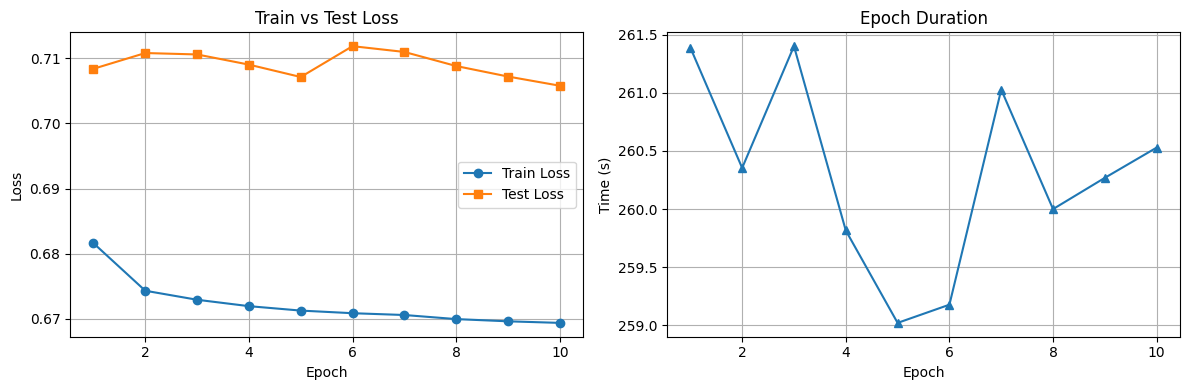

In [13]:
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch.nn.functional as F

import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_weights = copy.deepcopy(model.state_dict())
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_weights = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

# 初始化早停
early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# 在训练循环中使用


num_epochs = 10
train_losses = []
test_losses  = []
epoch_times  = []

for epoch in range(1, num_epochs + 1):
    # 训练阶段
    model.train()
    start_time = time.time()
    total_loss = 0.0
    for u_idx, n_idx, lbl in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False):
        u_idx, n_idx, lbl = u_idx.to(device), n_idx.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(data)
        u_emb = out['user'][u_idx]
        n_emb = out['news'][n_idx]
        logits = (u_emb * n_emb).sum(dim=1)
        loss   = F.binary_cross_entropy_with_logits(logits, lbl)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)

    # 测试阶段
    model.eval()
    total_test_loss = 0.0
    for u_idx, n_idx, lbl in tqdm(test_loader, desc=f"Epoch {epoch} Testing", leave=False):
        u_idx, n_idx, lbl = u_idx.to(device), n_idx.to(device), lbl.to(device)
        out = model(data)
        u_emb = out['user'][u_idx]
        n_emb = out['news'][n_idx]
        logits = (u_emb * n_emb).sum(dim=1)
        loss   = F.binary_cross_entropy_with_logits(logits, lbl)
        total_test_loss += loss.item()
    test_loss = total_test_loss / len(test_loader)

    elapsed = time.time() - start_time

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    epoch_times.append(elapsed)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, Time={elapsed:.1f}s")
    if early_stopping(test_loss, model):
        print(f"Early stopping triggered at epoch {epoch+1}")
        print(f"Best test loss: {early_stopping.best_loss:.4f}")
        break
# 绘图
# 绘图 - 修正：使用实际训练轮数
actual_epochs = len(train_losses)
epoch_range = range(1, actual_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epoch_range, train_losses, marker='o', label='Train Loss')
axes[0].plot(epoch_range, test_losses, marker='s', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train vs Test Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epoch_range, epoch_times, marker='^', label='Epoch Time (s)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Time (s)')
axes[1].set_title('Epoch Duration')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import roc_auc_score
import numpy as np
from collections import defaultdict
#8 evaluation
K = 10  # 你可以改成5、20等

model.eval()
ys, ps, us = [], [], []
with torch.no_grad():
    for u_idx, n_idx, lbl in test_loader:
        out = model(data)
        u_emb = out['user'][u_idx]
        n_emb = out['news'][n_idx]
        logits = (u_emb * n_emb).sum(dim=1)
        ys.append(lbl.cpu())
        ps.append(torch.sigmoid(logits).cpu())
        us.append(u_idx.cpu())
y_true = torch.cat(ys).numpy()
y_pred = torch.cat(ps).numpy()
user_idx = torch.cat(us).numpy()

# 1. AUC
auc = roc_auc_score(y_true, y_pred)
print(f'AUC: {auc:.4f}')

# 2. Top-K Precision/Recall, MRR, NDCG
user_pred = defaultdict(list)
user_true = defaultdict(list)
for u, t, p in zip(user_idx, y_true, y_pred):
    user_pred[u].append(p)
    user_true[u].append(t)

precisions, recalls, mrrs, ndcgs = [], [], [], []

def ndcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size == 0:
        return 0.0
    dcg = np.sum(r / np.log2(np.arange(2, r.size + 2)))
    idcg = np.sum(sorted(r, reverse=True)[:k] / np.log2(np.arange(2, r.size + 2)))
    return dcg / idcg if idcg > 0 else 0.0

for u in user_true:
    pred_scores = np.array(user_pred[u])
    true_labels = np.array(user_true[u])
    if true_labels.sum() == 0:
        continue  # 跳过没有正样本的用户
    # Top-K
    topk_idx = np.argsort(pred_scores)[::-1][:K]
    hits = true_labels[topk_idx].sum()
    precisions.append(hits / K)
    recalls.append(hits / true_labels.sum())
    # MRR
    sorted_idx = np.argsort(pred_scores)[::-1]
    sorted_true = true_labels[sorted_idx]
    rank = np.where(sorted_true == 1)[0]
    if len(rank) > 0:
        mrrs.append(1.0 / (rank[0] + 1))
    else:
        mrrs.append(0.0)
    # NDCG
    ndcgs.append(ndcg_at_k(sorted_true, K))

print(f'Precision@{K}: {np.mean(precisions):.4f}')
print(f'Recall@{K}: {np.mean(recalls):.4f}')
print(f'MRR: {np.mean(mrrs):.4f}')
print(f'NDCG@{K}: {np.mean(ndcgs):.4f}')

AUC: 0.7441
Precision@10: 0.1975
Recall@10: 0.4061
MRR: 0.5642
NDCG@10: 0.6129


In [15]:
#other code
# # 2. Sentiment Analysis on News Titles

# def get_sentiment(text):
#     if pd.isnull(text):
#         return 0
#     return TextBlob(str(text)).sentiment.polarity

# news['sentiment_score'] = news['Title'].apply(get_sentiment)
# print('News with sentiment:')
# print(news[['Title', 'sentiment_score']].head())

# # 2.1 Entity-level Sentiment Analysis

# entity_sentiment = {}
# for idx, row in news.iterrows():
#     try:
#         entities = ast.literal_eval(row['Title_Entities'])
#     except:
#         entities = []
#     for ent in entities:
#         ent_label = ent.get('Label', '')
#         if ent_label:
#             score = get_sentiment(row['Title'])  # 可改为更复杂的上下文分析
#             entity_sentiment[ent_label] = entity_sentiment.get(ent_label, []) + [score]
# # 平均每个实体的情感分数
# entity_sentiment_avg = {k: sum(v)/len(v) if v else 0 for k, v in entity_sentiment.items()}
# print('Sample entity sentiment:', list(entity_sentiment_avg.items())[:5])

# 2.1 新版 Entity-level Sentiment Analysis，考虑标题和摘要两个字段